In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import homogeneity_score

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import Normalizer
from sklearn.random_projection import GaussianRandomProjection

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
from random import sample

from sklearn.base import clone

random_state = 23523
scoring = 'roc_auc_ovo'

In [2]:
# --- load

X_bus = pd.read_pickle('data/business-classification/X.pkl')
Y_bus = pd.read_pickle('data/business-classification/Y.pkl')

X_wine = pd.read_pickle('data/wine/X.pkl')
Y_wine = pd.read_pickle('data/wine/Y.pkl')

# --- split

X_bus_train, X_bus_test, Y_bus_train, Y_bus_test = train_test_split(
    X_bus, Y_bus,
    test_size=0.3,
    random_state=random_state
)

X_wine_train, X_wine_test, Y_wine_train, Y_wine_test = train_test_split(
    X_wine, Y_wine,
    test_size=0.3,
    random_state=random_state
)

training_datasets = {
    'BusClass': (X_bus_train, Y_bus_train),
    'Wine': (X_wine_train, Y_wine_train)
}

holdout_datasets = {
    'BusClass': (X_bus_test, Y_bus_test),
    'Wine': (X_wine_test, Y_wine_test)
}

In [3]:
training_datasets['BusClass'][0]

,ability,able,accept,access,accessibility,accessories,account,achieve,act,action,...,worked,working,works,world,worldwide,www,year,years,york,youtube
60710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
31034,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
45323,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4256,0,0,0,0,0,0,1,0,0,1,...,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66968,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
622,0,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,0
62337,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
6112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [4]:
training_datasets['Wine'][0]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,red
1514,6.9,0.84,0.21,4.10,0.074,16.0,65.0,0.99842,3.53,0.72,9.233333,1
4229,6.3,0.26,0.25,5.20,0.046,11.0,133.0,0.99202,2.97,0.68,11.000000,0
1815,6.8,0.30,0.35,2.80,0.038,10.0,164.0,0.99120,3.09,0.53,12.000000,0
3713,6.6,0.28,0.23,10.40,0.049,45.0,190.0,0.99754,3.12,0.51,8.800000,0
2328,6.9,0.35,0.55,11.95,0.038,22.0,111.0,0.99687,3.11,0.29,9.700000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4260,6.2,0.36,0.22,5.25,0.038,44.0,145.0,0.99184,3.22,0.40,11.200000,0
622,10.0,0.58,0.22,1.90,0.080,9.0,32.0,0.99740,3.13,0.55,9.500000,1
3394,6.5,0.25,0.45,7.80,0.048,52.0,188.0,0.99576,3.20,0.53,9.100000,0
4513,6.8,0.40,0.29,2.80,0.044,27.0,97.0,0.99040,3.12,0.42,11.200000,0


# Step 1.

## K-Means

In [185]:
# KMeans
scores = {
    'BusClass': pd.DataFrame(columns=['Silhouette', 'CH', 'Homogeneity']),
    'Wine':     pd.DataFrame(columns=['Silhouette', 'CH', 'Homogeneity'])
}
for dataset_name in training_datasets:
    for k in [2, 3, 4, 5, 6]:
        X, y = training_datasets[dataset_name]
        clustering_model = KMeans(
            n_clusters=k,
            random_state=random_state
        )
        clustering_model.fit(X)
        labels = clustering_model.labels_
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X.values, labels)
        homog = homogeneity_score(y, labels)
        print(f'Score for k={k} on {dataset_name}: SS={sil_score:.2f} CH={ch_score:.2f}')
        scores[dataset_name].loc[k, 'Silhouette'] = sil_score
        scores[dataset_name].loc[k, 'CH'] = ch_score
        # scores[dataset_name].loc[k, 'Homogeneity'] = homog
        
    scores[dataset_name].index.name = 'k'
        

Score for k=2 on BusClass: SS=0.12 CH=2037.27
Score for k=3 on BusClass: SS=0.03 CH=1355.42
Score for k=4 on BusClass: SS=0.03 CH=1028.80
Score for k=5 on BusClass: SS=-0.03 CH=842.51
Score for k=6 on BusClass: SS=-0.03 CH=728.30
Score for k=2 on Wine: SS=0.51 CH=7615.76
Score for k=3 on Wine: SS=0.50 CH=9641.89
Score for k=4 on Wine: SS=0.45 CH=9860.93
Score for k=5 on Wine: SS=0.42 CH=9710.95
Score for k=6 on Wine: SS=0.39 CH=9228.25


In [184]:
scores['BusClass']

,Silhouette,CH,AIC,BIC
k,,,,


In [186]:
scores['Wine'].iloc[:, :-1]

,Silhouette,CH
k,,
2,0.512885,7615.757641
3,0.502181,9641.885126
4,0.452646,9860.930992
5,0.421842,9710.949745
6,0.391662,9228.247708


We'll select $k = 2$ for business classification and $k = 4$ for the wine model.

### Validate Clusters

#### Graphical Views

Bus class (given that it's design matrix is all booleans) model doesn't lend itself well to pairwise plots.

<Figure size 640x480 with 0 Axes>

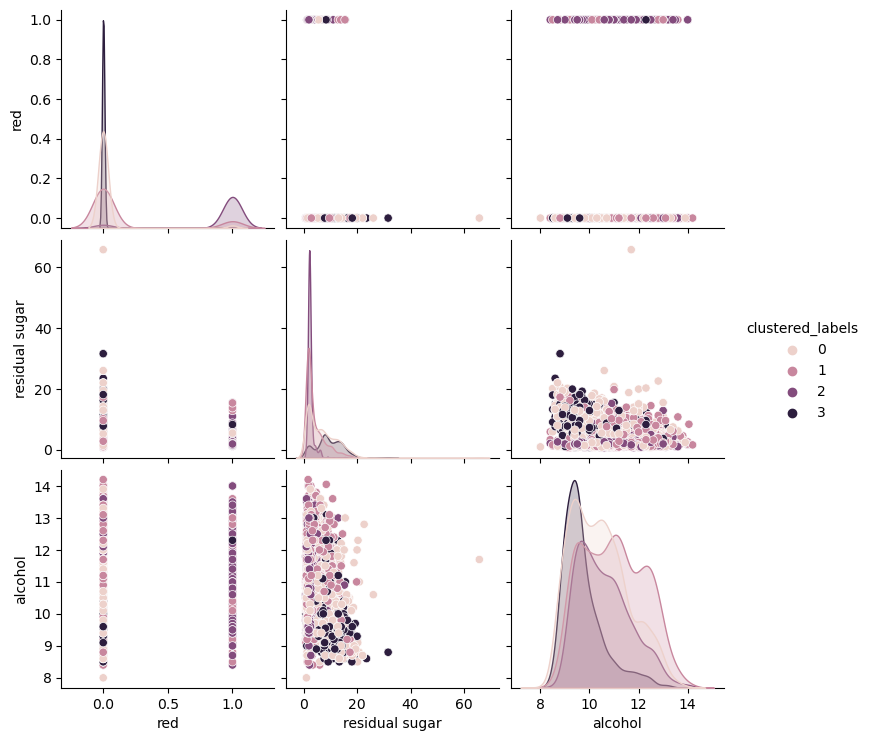

In [8]:
dataset_name = 'Wine'
tmp = training_datasets[dataset_name][0].copy()
model = KMeans(
    n_clusters=4,
    random_state=random_state
)
model.fit(tmp)
features_of_interest = ['red', 'residual sugar', 'alcohol']
tmp = tmp[features_of_interest].copy()
tmp.loc[:, 'clustered_labels'] = model.labels_
for col in tmp:
    tmp.loc[:, col] = np.array(tmp[col])
tmp.reset_index(drop=True, inplace=True)

plt.clf()
sns.pairplot(
    tmp,
    hue="clustered_labels",
    vars=features_of_interest
)
#.set(title=f'{dataset_name} K-Means Pair-plot')
plt.show()

#### For business classification, what industries are generally represented in one cluster?

In [9]:
X = training_datasets['BusClass'][0].copy()
model = KMeans(
    n_clusters=2,
    random_state=random_state
)
model.fit(X)

df = pd.DataFrame({
    'Cluster': model.labels_,
    'Industry Group': training_datasets['BusClass'][1].copy()
})

true_label_proportions = df.groupby(['Cluster', 'Industry Group']).size().unstack(level=0).fillna(0)
true_label_proportions = true_label_proportions.div(true_label_proportions.sum(axis=0), axis=1)
true_label_proportions.round(2).assign(diff = lambda x: x[1] - x[0]).sort_values('diff')

Cluster,0,1,diff
Industry Group,,,
Financials,0.14,0.07,-0.07
Information Technology,0.13,0.06,-0.07
Professional Services,0.12,0.09,-0.03
Healthcare,0.10,0.09,-0.01
Commercial Services & Supplies,0.09,0.09,0.00
Corporate Services,0.09,0.09,0.00
"Media, Marketing & Sales",0.09,0.09,0.00
Energy & Utilities,0.07,0.08,0.01
Consumer Discretionary,0.03,0.04,0.01


Very cool! Although it's hard to see valuable groupings at the individual industry group level, it totally looks like the model was able to separate by white collar work vs. blue collar work.

#### For wine quality classification, what qualities are generally represented in one cluster?

In [10]:
X = training_datasets['Wine'][0].copy()
model = KMeans(
    n_clusters=4,
    random_state=random_state
)
model.fit(X)

df = pd.DataFrame({
    'Cluster': model.labels_,
    'Wine Quality': training_datasets['Wine'][1].copy()
})

true_label_proportions = df.groupby(['Cluster', 'Wine Quality']).size().unstack(level=0).fillna(0)
true_label_proportions = true_label_proportions.div(true_label_proportions.sum(axis=0), axis=1).sort_values(0)
true_label_proportions.loc[['Low', 'Medium', 'High']].round(2)

Cluster,0,1,2,3
Wine Quality,,,,
Low,0.33,0.28,0.42,0.50
Medium,0.43,0.46,0.42,0.42
High,0.24,0.25,0.15,0.08


Although it struggled with the medium quality wine, the clusters are able to help separate the low and high quality items

## E-M

In [11]:
em_scores = {
    'Wine':     pd.DataFrame(columns=['AIC', 'BIC']),
    'BusClass': pd.DataFrame(columns=['AIC', 'BIC'])
}
for dataset_name in em_scores:
    for k in [2, 3, 4, 5, 6]:
        X, _ = training_datasets[dataset_name]
        clustering_model = GaussianMixture(
            n_components=k,
            random_state=random_state,
            init_params='random_from_data'
        )
        clustering_model.fit(X.values)
        bic = clustering_model.bic(X.values)
        aic = clustering_model.aic(X.values)
        print(f'Score for k={k} on {dataset_name}: AIC={aic:,.2f} BIC={bic:,.2f}')
        em_scores[dataset_name].loc[k, 'AIC'] = aic
        em_scores[dataset_name].loc[k, 'BIC'] = bic
        

Score for k=2 on Wine: AIC=-6,932.99 BIC=-5,770.57
Score for k=3 on Wine: AIC=-22,839.47 BIC=-21,092.63
Score for k=4 on Wine: AIC=-23,264.08 BIC=-20,932.82
Score for k=5 on Wine: AIC=-23,318.14 BIC=-20,402.45
Score for k=6 on Wine: AIC=-24,350.45 BIC=-20,850.34
Score for k=2 on BusClass: AIC=-434,216.62 BIC=8,447,135.13
Score for k=3 on BusClass: AIC=-551,684.59 BIC=12,770,347.48
Score for k=4 on BusClass: AIC=-268,296.33 BIC=17,494,416.03
Score for k=5 on BusClass: AIC=-1,693,635.59 BIC=20,509,757.08
Score for k=6 on BusClass: AIC=-1,396,066.59 BIC=25,248,006.39


For business classification: BIC says 2, AIC says 5. We'll use BIC's recommendation because it takes into account our dataset size. For wine it's the reverse, but we'll stick with BIC and select 3.

### Validate Clusters

#### For business classification, what industries are generally represented in one cluster?

In [12]:
X = training_datasets['BusClass'][0].copy()
model = GaussianMixture(
    n_components=2,
    random_state=random_state,
    init_params='random_from_data'
)
model.fit(X.values)

df = pd.DataFrame({
    'Cluster': model.predict(X.values),
    'Industry Group': training_datasets['BusClass'][1].copy()
})

true_label_proportions = df.groupby(['Cluster', 'Industry Group']).size().unstack(level=0).fillna(0)
true_label_proportions = true_label_proportions.div(true_label_proportions.sum(axis=0), axis=1)
true_label_proportions.round(2).assign(diff = lambda x: x[1] - x[0]).sort_values('diff')

Cluster,0,1,diff
Industry Group,,,
Information Technology,0.22,0.08,-0.14
"Media, Marketing & Sales",0.19,0.09,-0.10
Energy & Utilities,0.09,0.08,-0.01
Consumer Discretionary,0.03,0.04,0.01
Materials,0.03,0.04,0.01
Consumer Staples,0.06,0.07,0.01
Commercial Services & Supplies,0.07,0.09,0.02
Corporate Services,0.07,0.09,0.02
Transportation & Logistics,0.07,0.09,0.02


See less of a trend here. Why?

#### For wine quality classification, what levels are generally represented in one cluster?

In [13]:
X = training_datasets['Wine'][0].copy()
model = GaussianMixture(
    n_components=3,
    random_state=random_state,
    init_params='random_from_data'
)
model.fit(X.values)

df = pd.DataFrame({
    'Cluster': model.predict(X.values),
    'Wine Quality': training_datasets['Wine'][1].copy()
})

true_label_proportions = df.groupby(['Cluster', 'Wine Quality']).size().unstack(level=0).fillna(0)
true_label_proportions = true_label_proportions.div(true_label_proportions.sum(axis=0), axis=1).sort_values(0)
true_label_proportions.loc[['Low', 'Medium', 'High']].round(2)

Cluster,0,1,2
Wine Quality,,,
Low,0.62,0.47,0.27
Medium,0.36,0.39,0.47
High,0.03,0.14,0.26


See a more pronounced trend here. Why?

# Step 2.

## PCA

In [24]:
dataset_name = 'BusClass'
X, y = training_datasets[dataset_name]
reducer = PCA(
    n_components=30,
    random_state=random_state
)
reducer.fit(X.values)
reducer.explained_variance_ratio_

array([0.06124682, 0.01575141, 0.01186641, 0.01077886, 0.01019333,
       0.00827814, 0.00675442, 0.00653022, 0.00605566, 0.00575474,
       0.00560247, 0.00477969, 0.00473371, 0.00441624, 0.00418869,
       0.00391609, 0.00382708, 0.00373045, 0.00371174, 0.00358392,
       0.00345523, 0.00337092, 0.00325202, 0.00314405, 0.00309948,
       0.00301296, 0.00295826, 0.00292573, 0.00283362, 0.00279152])

<Figure size 640x480 with 0 Axes>

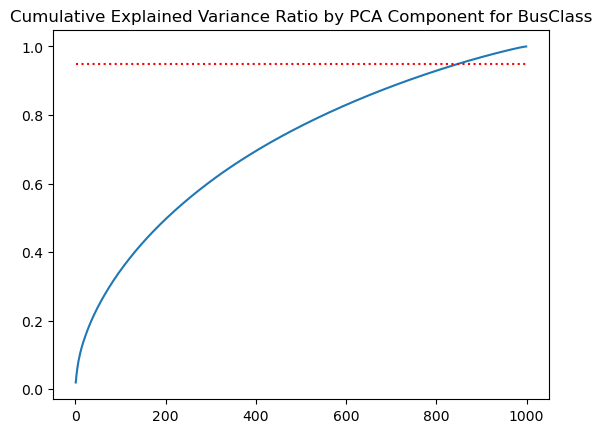

Exceeds 95% at 851


<Figure size 640x480 with 0 Axes>

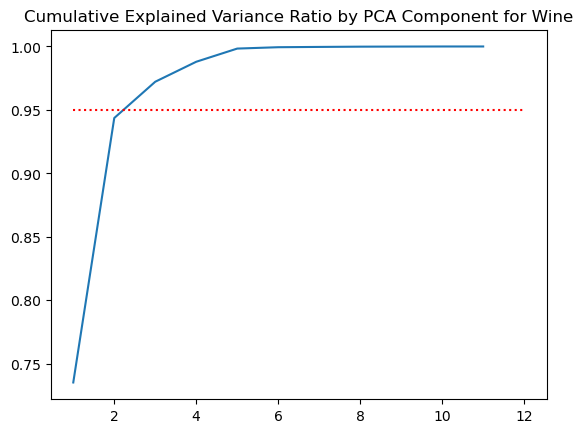

Exceeds 95% at 3


In [86]:
for dataset_name in training_datasets:
    X, y = training_datasets[dataset_name]
    num_components = min(X.shape[1] - 1, 1000)
    reducer = make_pipeline(
        Normalizer(),
        PCA(
            n_components=num_components,
            random_state=random_state
        )
    )    
    reducer.fit(X.values)
    plt.clf()
    fig, ax = plt.subplots()
    d = pd.Series(reducer.named_steps['pca'].explained_variance_ratio_.cumsum(), index=range(1, num_components + 1))
    d.plot(
        title=f'Cumulative Explained Variance Ratio by PCA Component for {dataset_name}',
        ax=ax
    )
    ax.hlines(y=0.95,xmin=1,xmax=X.shape[1], color='red', linestyles='dotted')
    plt.show()
    print(f'Exceeds 95% at {d[d > 0.95].index[0]}')

We'll use 851 components for Business Classification and only 3 for Wine.

#### Meandering

Since we have such good results for PCA on wine with relatively few components, does this also mean that our reconstruction error is minimal?

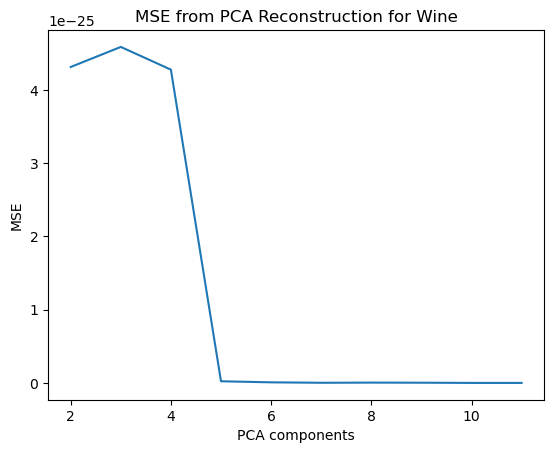

In [187]:
X, y = training_datasets['Wine']
errors = []
opts = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
opts = [o for o in opts if o < X.shape[1]]
X_values = Normalizer().fit_transform(X.values)
# X_values = X.values
for k in opts:
    reducer = PCA(
        n_components=k,
        random_state=random_state
    )
    X_reconstructed = reducer.inverse_transform(
        reducer.fit_transform(X_values)
    )
    mse = np.sum((X_values - X_reconstructed)) ** 2
    errors.append(mse)
plt.clf()
pd.Series(errors, index=opts).plot(
    title=f'MSE from PCA Reconstruction for {dataset_name}',
    xlabel='PCA components',
    ylabel='MSE'
)
plt.show()

### ICA

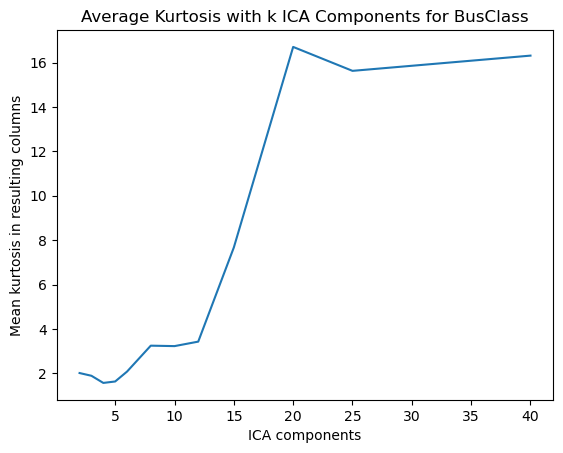

C:\Users\rache\miniconda3\envs\cs-7641-env\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


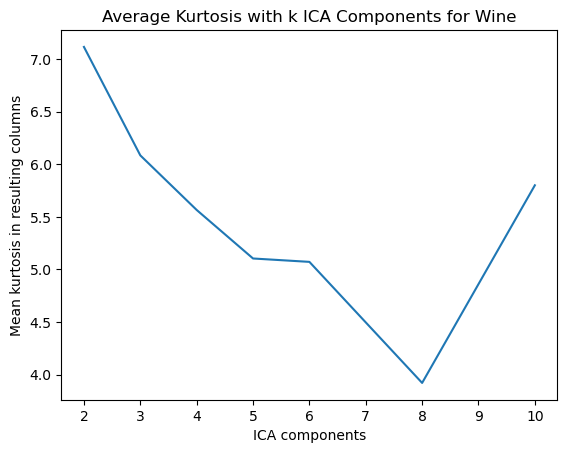

In [21]:
for dataset_name in training_datasets:
    X, y = training_datasets[dataset_name]
    kurtoses = []
    opts = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 40]
    opts = [o for o in opts if o < X.shape[1]]
    for k in opts:
        reducer = FastICA(
            n_components=k,
            random_state=random_state,
            whiten='unit-variance'
        )
        kurtoses.append(
            pd.DataFrame(reducer.fit_transform(X.values)).kurtosis().mean()
        )
    plt.clf()
    pd.Series(kurtoses, index=opts).plot(
        title=f'Average Kurtosis with k ICA Components for {dataset_name}',
        xlabel='ICA components',
        ylabel='Mean kurtosis in resulting columns'
    )
    plt.show()

### Random Projection

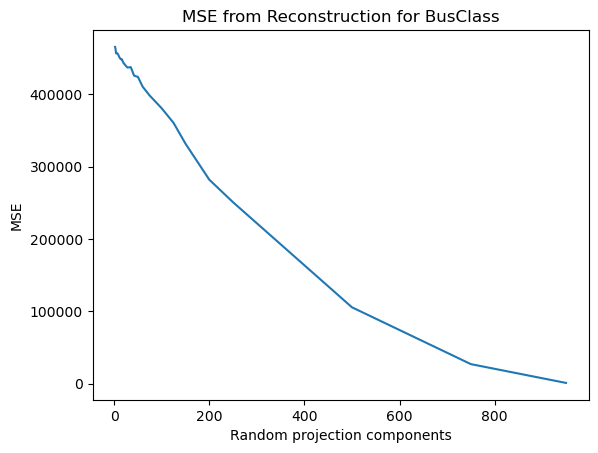

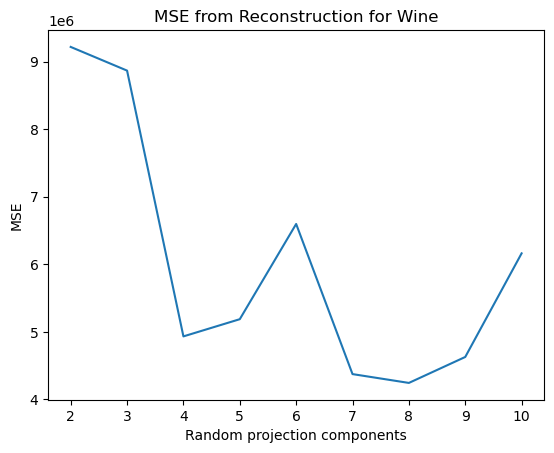

In [41]:
for dataset_name in training_datasets:
    X, y = training_datasets[dataset_name]
    errors = []
    opts = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 20, 24, 28, 35, 42, 50, 60, 75, 100, 125, 150, 200, 250, 500, 750, 950]
    opts = [o for o in opts if o < X.shape[1]]
    for k in opts:
        reducer = GaussianRandomProjection(
            n_components=k,
            random_state=random_state,
            compute_inverse_components=True
        )
        X_values = X.values
        X_reconstructed = reducer.inverse_transform(
            reducer.fit_transform(X_values)
        )
        mse = np.sum((X_values - X_reconstructed)) ** 2 / np.prod(X.shape)
        errors.append(mse)
    plt.clf()
    pd.Series(errors, index=opts).plot(
        title=f'MSE from Reconstruction for {dataset_name}',
        xlabel='Random projection components',
        ylabel='MSE'
    )
    plt.show()


Seeing little improvement for

## 4th Dim. Reducer - LDA

<Figure size 640x480 with 0 Axes>

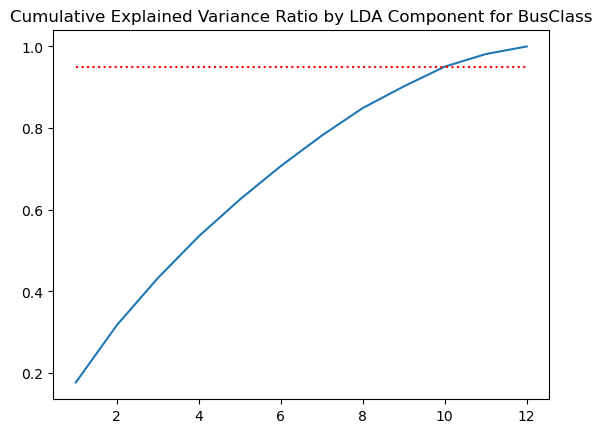

Exceeds 95% at 10


<Figure size 640x480 with 0 Axes>

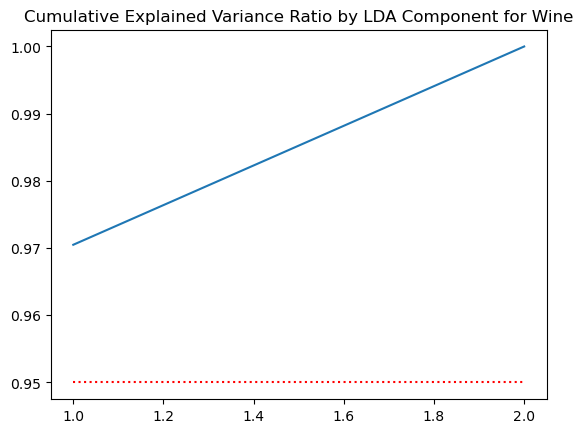

Exceeds 95% at 1


In [101]:
for dataset_name in training_datasets:
    X, y = training_datasets[dataset_name]
    num_components = min(X.shape[1] - 1, y.nunique() - 1)
    reducer = LinearDiscriminantAnalysis(
        n_components=num_components
    )
    X_values = X.values
    reducer.fit(X_values, y)

    plt.clf()
    fig, ax = plt.subplots()
    d = pd.Series(reducer.explained_variance_ratio_.cumsum(), index=range(1, num_components + 1))
    d.plot(
        title=f'Cumulative Explained Variance Ratio by LDA Component for {dataset_name}',
        ax=ax
    )
    ax.hlines(y=0.95,xmin=1,xmax=num_components, color='red', linestyles='dotted')
    plt.show()
    print(f'Exceeds 95% at {d[d > 0.95].index[0]}')


# Step 3

In [117]:
template = pd.DataFrame(columns=['Clustering', 'Dim Reduction', 'k', 'Silhouette', 'CH', 'AIC', 'BIC'])
scores_3 = {
    'BusClass': template.copy(),
    'Wine': template.copy()
}

for dataset_name in training_datasets:
    X, y = training_datasets[dataset_name]
    X_norm = Normalizer().fit_transform(X.values)
    for dim_reduction_class in [GaussianRandomProjection, PCA, FastICA, LinearDiscriminantAnalysis]:
        dim_red_technique = str(dim_reduction_class.__name__)
        if dim_red_technique == 'GaussianRandomProjection':
            dim_reducer = dim_reduction_class(
                random_state=random_state,
                n_components=min(X.shape[1] - 1, 100)
            )
        elif dim_red_technique == 'LinearDiscriminantAnalysis':
            dim_reducer = dim_reduction_class()
        else:
            dim_reducer = dim_reduction_class(
                random_state=random_state
            )
        X_reduced = dim_reducer.fit_transform(X_norm, y)
        
        for k in [2, 3, 4, 5, 6]:
            # K Means
            clustering_model = KMeans(
                n_clusters=k,
                random_state=random_state
            )
            clustering_model.fit(X)
            labels = clustering_model.labels_
            sil_score = silhouette_score(X, labels)
            ch_score = calinski_harabasz_score(X.values, labels)
            scores_3[dataset_name] = scores_3[dataset_name].append(
                {'Clustering': 'K-Means',
                 'Dim Reduction': dim_red_technique,
                 'k': k,
                 'Silhouette': sil_score,
                 'CH': ch_score}, 
                ignore_index=True
            )
            
            # Gaussian Mixture
            clustering_model = GaussianMixture(
                n_components=k,
                random_state=random_state,
                init_params='random_from_data'
            )
            clustering_model.fit(X.values)
            bic = clustering_model.bic(X.values)
            aic = clustering_model.aic(X.values)
            scores_3[dataset_name] = scores_3[dataset_name].append(
                {'Clustering': 'E-M',
                 'Dim Reduction': dim_red_technique,
                 'k': k,
                 'AIC': aic,
                 'BIC': bic}, 
                ignore_index=True
            )
                

C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_nam

C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_nam

C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_name] = scores_3[dataset_name].append(
C:\Users\rache\AppData\Local\Temp\ipykernel_11616\3596359417.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_3[dataset_nam

In [161]:
scores_3_complete = pd.concat([scores_3['BusClass'].assign(Dataset='BusClass'), scores_3['Wine'].assign(Dataset='Wine')])
scores_3_complete.to_csv('step 3.csv')

In [125]:
scores_3['BusClass']

,Clustering,Dim Reduction,k,Silhouette,CH,AIC,BIC
0,K-Means,GaussianRandomProjection,2,0.124604,2037.269579,NaN,NaN
1,E-M,GaussianRandomProjection,2,NaN,NaN,-4.342166e+05,8.447135e+06
2,K-Means,GaussianRandomProjection,3,0.031308,1355.421528,NaN,NaN
3,E-M,GaussianRandomProjection,3,NaN,NaN,-5.516846e+05,1.277035e+07
4,K-Means,GaussianRandomProjection,4,0.025225,1028.804801,NaN,NaN
5,E-M,GaussianRandomProjection,4,NaN,NaN,-2.682963e+05,1.749442e+07
6,K-Means,GaussianRandomProjection,5,-0.033564,842.513825,NaN,NaN
7,E-M,GaussianRandomProjection,5,NaN,NaN,-1.693636e+06,2.050976e+07
8,K-Means,GaussianRandomProjection,6,-0.029091,728.297014,NaN,NaN
9,E-M,GaussianRandomProjection,6,NaN,NaN,-1.396067e+06,2.524801e+07


In [124]:
scores_3['Wine']

,Clustering,Dim Reduction,k,Silhouette,CH,AIC,BIC
0,K-Means,GaussianRandomProjection,2,0.512885,7615.757641,NaN,NaN
1,E-M,GaussianRandomProjection,2,NaN,NaN,-6932.988756,-5770.566401
2,K-Means,GaussianRandomProjection,3,0.502181,9641.885126,NaN,NaN
3,E-M,GaussianRandomProjection,3,NaN,NaN,-22839.472712,-21092.628069
4,K-Means,GaussianRandomProjection,4,0.452646,9860.930992,NaN,NaN
5,E-M,GaussianRandomProjection,4,NaN,NaN,-23264.082973,-20932.816041
6,K-Means,GaussianRandomProjection,5,0.421842,9710.949745,NaN,NaN
7,E-M,GaussianRandomProjection,5,NaN,NaN,-23318.143411,-20402.454190
8,K-Means,GaussianRandomProjection,6,0.391662,9228.247708,NaN,NaN
9,E-M,GaussianRandomProjection,6,NaN,NaN,-24350.446592,-20850.335083


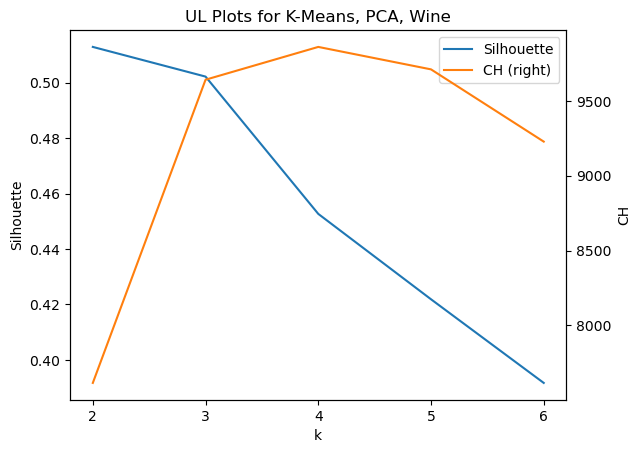

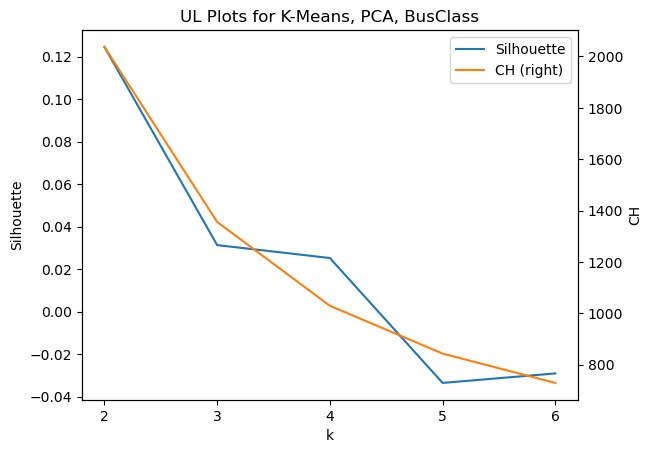

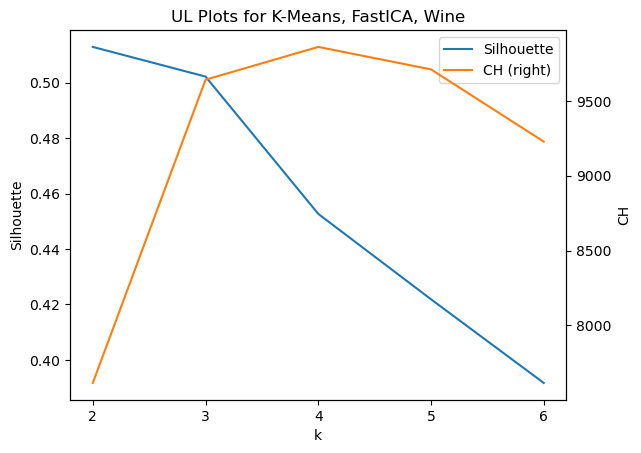

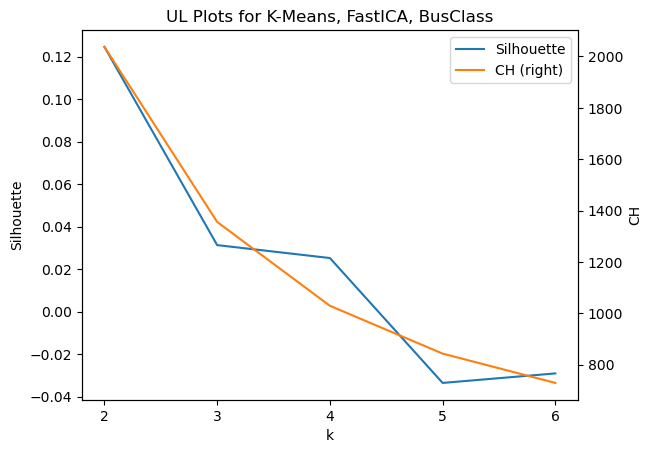

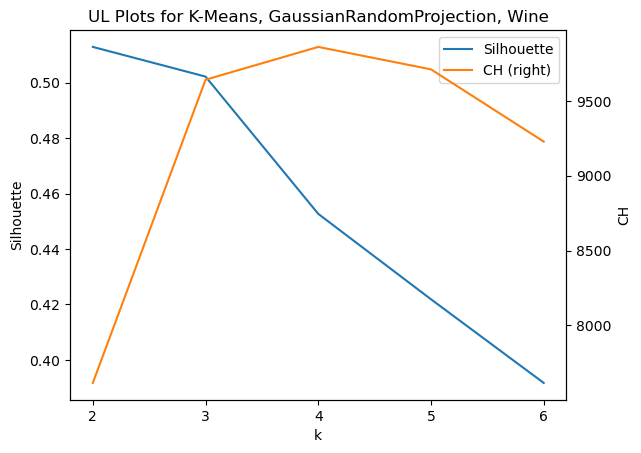

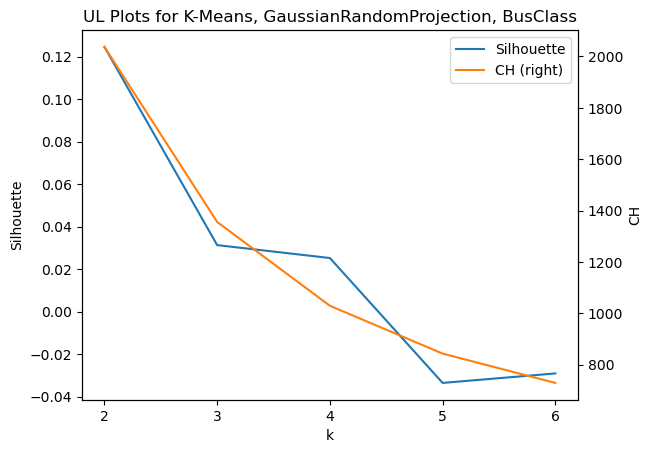

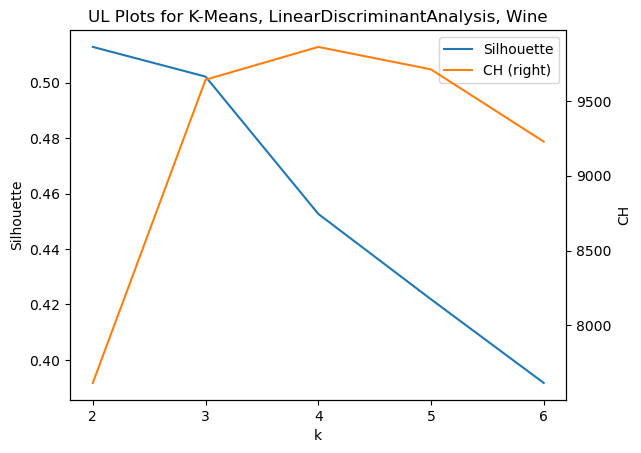

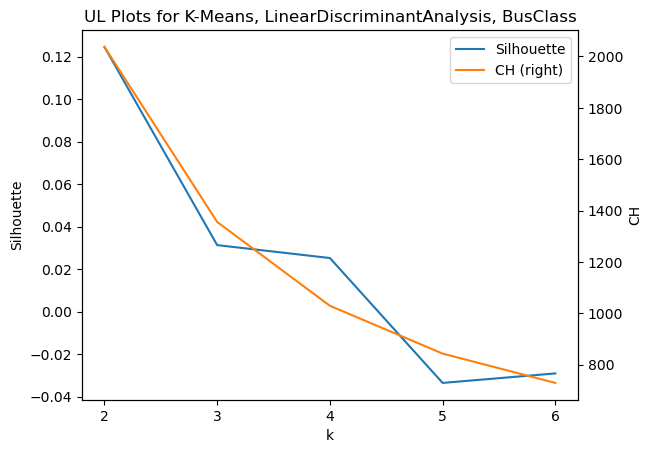

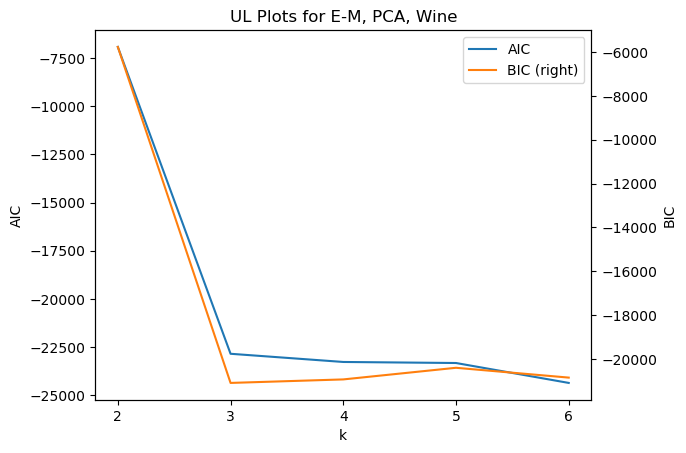

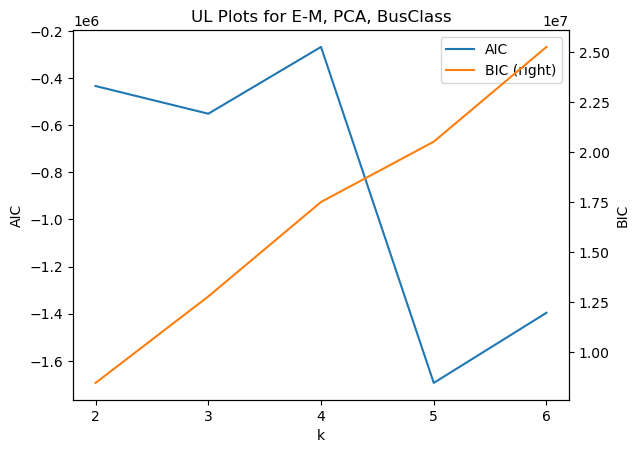

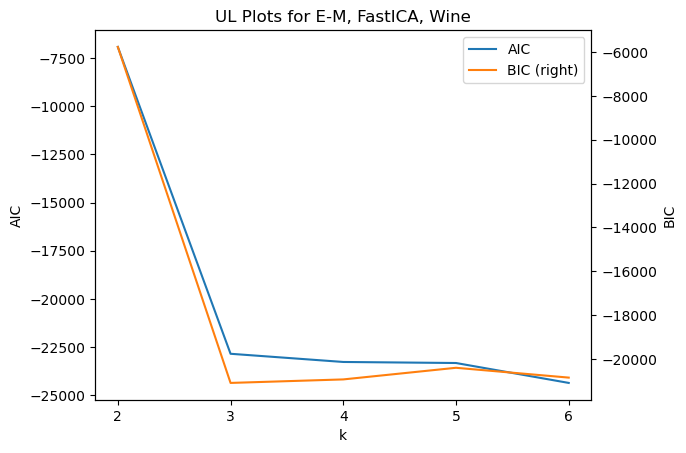

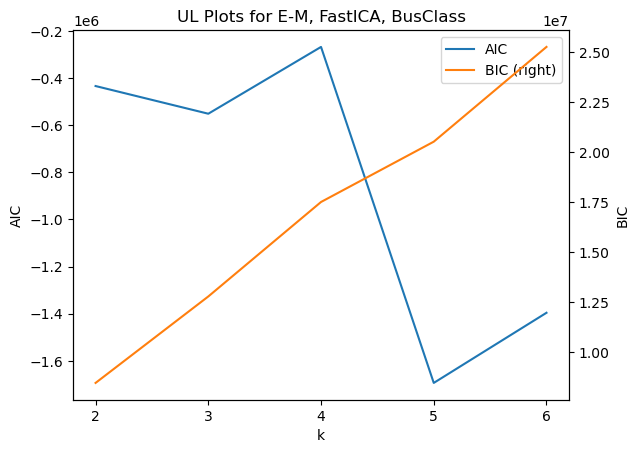

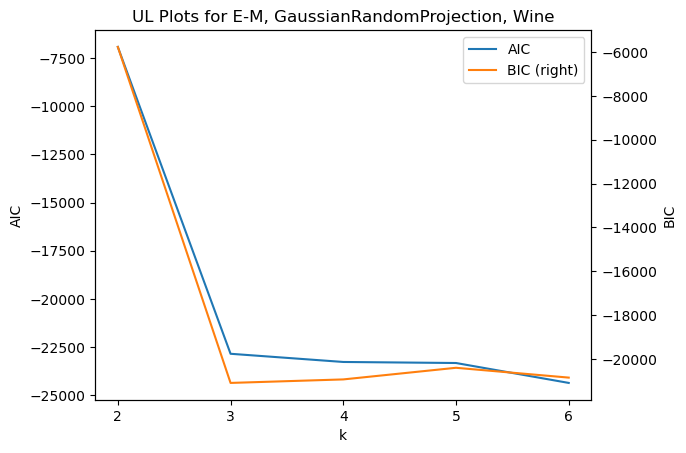

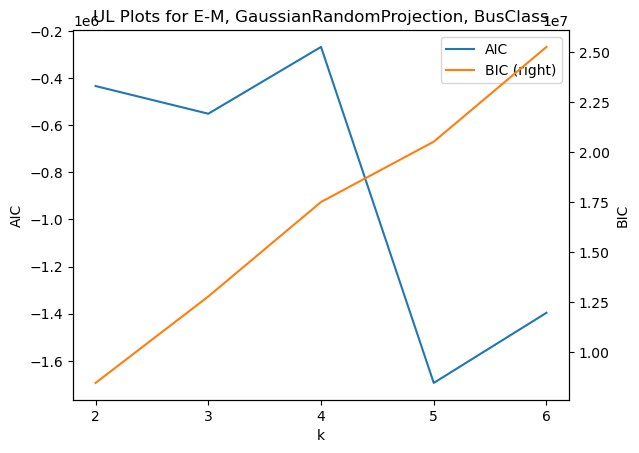

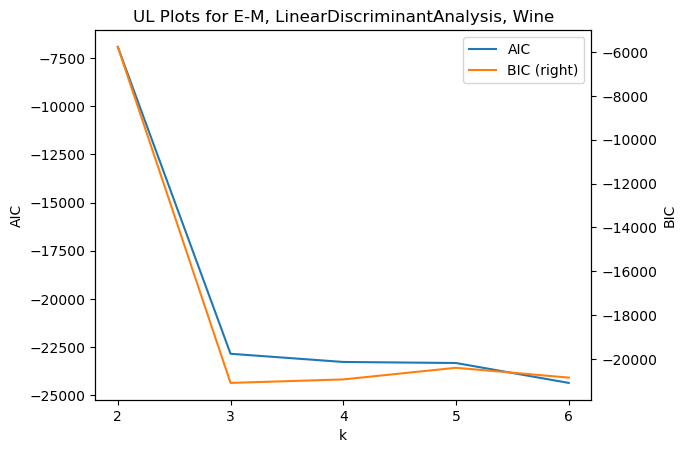

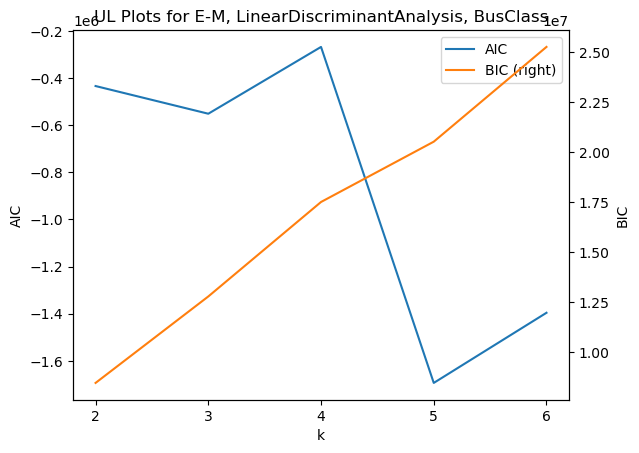

In [180]:
#fig, axes = plt.subplots(nrows=4, ncols=4)
i = 0
for clustering in ['K-Means', 'E-M']:
    for dim_reduct in ['PCA', 'FastICA', 'GaussianRandomProjection', 'LinearDiscriminantAnalysis']:
        for dataset in ['Wine', 'BusClass']:
            subset = scores_3_complete.copy()
            subset['k'] = subset['k'].astype(int)
            subset = subset.loc[
                (subset['Clustering'] == clustering)
                & (subset['Dim Reduction'] == dim_reduct)
                & (subset['Dataset'] == dataset)
            ]
            subset.set_index('k', inplace=True)
            subset = subset.loc[:, 'Silhouette':'BIC']
            subset = subset.dropna(axis=1)
            score1, score2 = subset.columns
            ax = subset.plot(
                y=[score1, score2], secondary_y=score2, ylabel=score1,
                xticks=[2, 3, 4, 5, 6],
                title=f'UL Plots for {clustering}, {dim_reduct}, {dataset}'#,
                #ax=axes[i // 4, i % 4]
            )
            ax.right_ax.set_ylabel(score2)
            i += 1


# Step 4

holdout scores: {'Original': 0.661123760893838}


<Figure size 640x480 with 0 Axes>

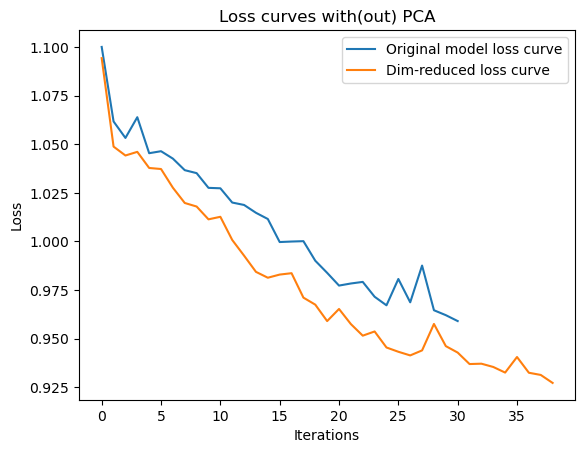

holdout scores: {'Original': 0.661123760893838, 'PCA': 0.6369429842930545}


C:\Users\rache\miniconda3\envs\cs-7641-env\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

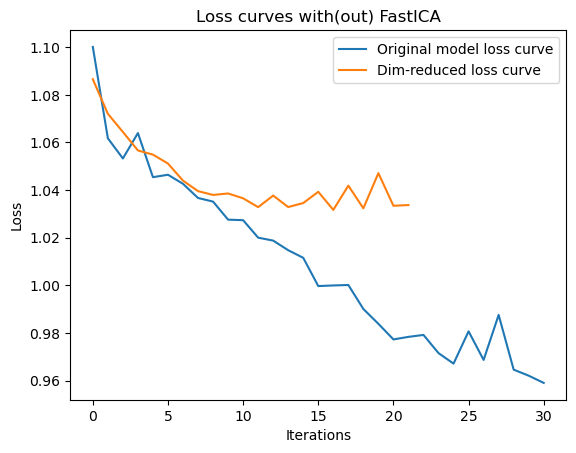

C:\Users\rache\miniconda3\envs\cs-7641-env\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


holdout scores: {'Original': 0.661123760893838, 'PCA': 0.6369429842930545, 'FastICA': 0.5898059697352442}


<Figure size 640x480 with 0 Axes>

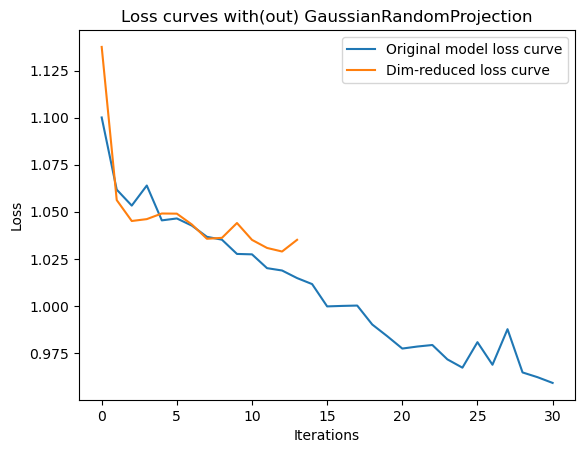

holdout scores: {'Original': 0.661123760893838, 'PCA': 0.6369429842930545, 'FastICA': 0.5898059697352442, 'GaussianRandomProjection': 0.5555925188896925}


<Figure size 640x480 with 0 Axes>

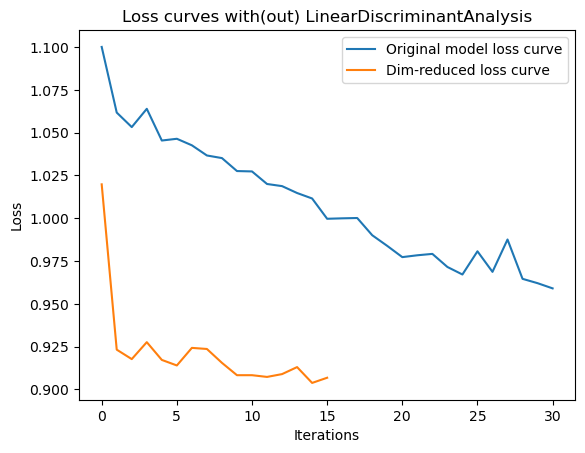

holdout scores: {'Original': 0.661123760893838, 'PCA': 0.6369429842930545, 'FastICA': 0.5898059697352442, 'GaussianRandomProjection': 0.5555925188896925, 'LinearDiscriminantAnalysis': 0.7229148088714767}


In [154]:
dataset_name = 'Wine'
X, y = training_datasets[dataset_name]
existing_normalizer = Normalizer()
X_norm = existing_normalizer.fit_transform(X.values)

X_holdout, y_holdout = holdout_datasets[dataset_name]
X_holdout_norm = existing_normalizer.transform(X_holdout.values)

grid_search = GridSearchCV(
    estimator=MLPClassifier(
        activation='logistic',
        max_iter=100,
        random_state=random_state,
        learning_rate_init=0.03,
        early_stopping=True
    ),
    param_grid={
        'alpha': [0] + [2 ** x for x in range(-6, 3, 4)],
        'hidden_layer_sizes': [(100,), (50,)]
    },
    scoring=scoring
)

original_model = clone(grid_search)
original_model.fit(X_norm, y)
selected_original = clone(original_model.best_estimator_).fit(X_norm, y)

def get_holdout_score(model, X_holdout_norm):
    Y_pred = model.predict_proba(X_holdout_norm)
    score = roc_auc_score(
        y_holdout,
        Y_pred,
        multi_class="ovo"
    )
    return score

holdout_scores = {
    'Original': get_holdout_score(selected_original, X_holdout_norm)
}
print('holdout scores:', holdout_scores)

dim_reduction_classes_and_k = [
    (PCA, 6),
    (FastICA, 4),
    (GaussianRandomProjection, 12),
    (LinearDiscriminantAnalysis, 2)
]
    
for dim_reduction_class, k in dim_reduction_classes_and_k:
    dim_red_technique = str(dim_reduction_class.__name__)
    if dim_red_technique == 'LinearDiscriminantAnalysis':
        dim_reducer = dim_reduction_class(
            n_components=k
        )
    else:
        dim_reducer = dim_reduction_class(
            random_state=random_state,
            n_components=k
        )
    X_reduced = dim_reducer.fit_transform(X_norm, y)
    
    dim_reduced_model = clone(grid_search)
    dim_reduced_model.fit(X_reduced, y)
    selected_reduced = clone(dim_reduced_model.best_estimator_).fit(X_reduced, y)
    
    df_length = max(len(selected_original.loss_curve_), len(selected_reduced.loss_curve_))
    results = pd.DataFrame(index=range(df_length), columns=['Original model loss curve', 'Dim-reduced loss curve'])
    for i, loss_original in enumerate(selected_original.loss_curve_):
        results.loc[i, 'Original model loss curve'] = loss_original
    for i, loss_reduced in enumerate(selected_reduced.loss_curve_):
        results.loc[i, 'Dim-reduced loss curve'] = loss_reduced
        
    plt.clf()
    results.plot(
        y=['Original model loss curve', 'Dim-reduced loss curve'],
        title=f'Loss curves with(out) {dim_red_technique}',
        ylabel='Loss',
        xlabel='Iterations'
    )
    plt.show()
    
    holdout_scores[dim_red_technique] = get_holdout_score(
        selected_reduced,
        dim_reducer.fit_transform(X_holdout_norm, y_holdout)
    )
    print('holdout scores:', holdout_scores)

 This didn't work well when I tried it with using the best values learned from step 2; instead it seemed like I needed more components, generally.

# Step 5

holdout scores: {'Original': 0.721280993355473}


<Figure size 640x480 with 0 Axes>

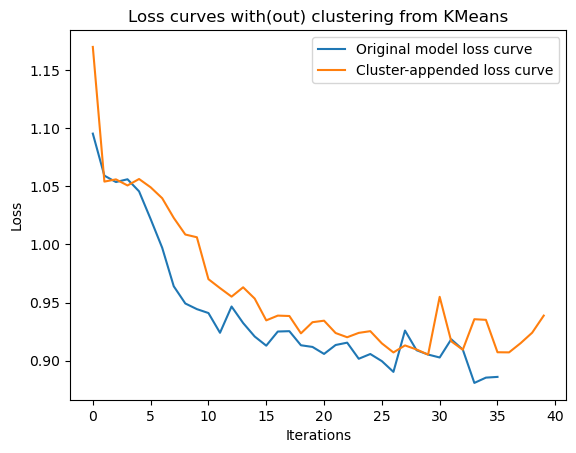

C:\Users\rache\miniconda3\envs\cs-7641-env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


holdout scores: {'Original': 0.721280993355473, 'KMeans': 0.7138685861654794}


<Figure size 640x480 with 0 Axes>

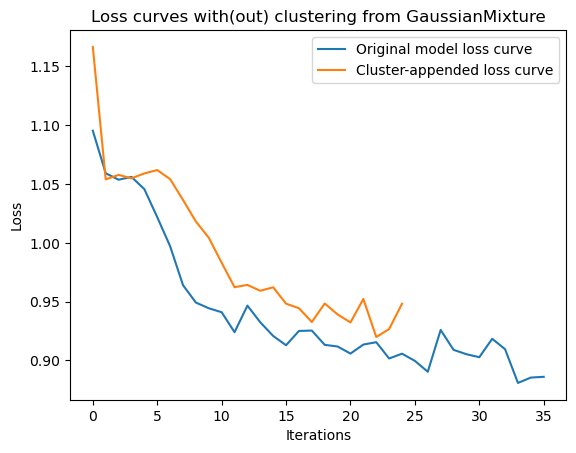

holdout scores: {'Original': 0.721280993355473, 'KMeans': 0.7138685861654794, 'GaussianMixture': 0.6885182002514311}


C:\Users\rache\miniconda3\envs\cs-7641-env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(


In [160]:
dataset_name = 'Wine'
X, y = training_datasets[dataset_name]

X_holdout, y_holdout = holdout_datasets[dataset_name]

X.columns = X.columns.str.replace(' ', '_')
X_holdout.columns = X_holdout.columns.str.replace(' ', '_')

grid_search = GridSearchCV(
    estimator=MLPClassifier(
        activation='logistic',
        max_iter=100,
        random_state=random_state,
        learning_rate_init=0.03,
        early_stopping=True
    ),
    param_grid={
        'alpha': [0] + [2 ** x for x in range(-6, 3, 4)],
        'hidden_layer_sizes': [(100,), (50,)]
    },
    scoring=scoring
)

original_model = clone(grid_search)
original_model.fit(X.values, y)
selected_original = clone(original_model.best_estimator_).fit(X.values, y)

def get_holdout_score(model, X_holdout):
    Y_pred = model.predict_proba(X_holdout)
    score = roc_auc_score(
        y_holdout,
        Y_pred,
        multi_class="ovo"
    )
    return score

holdout_scores = {
    'Original': get_holdout_score(selected_original, X_holdout.values)
}
print('holdout scores:', holdout_scores)

dim_reduction_classes_and_k = [
    (KMeans, 4),
    (GaussianMixture, 3)
]
    
for clustering_class, k in dim_reduction_classes_and_k:
    clustering_technique = str(clustering_class.__name__)
    if clustering_technique == 'KMeans':
        clustering = clustering_class(
            random_state=random_state,
            n_clusters=k
        )
    else:
        clustering = clustering_class(
            random_state=random_state,
            n_components=k
        )
    clustering.fit(X.values, y)
    X_with_clusters = X.copy()
    X_with_clusters['cluster_label'] = clustering.predict(X.values)
    
    clustered_model = clone(grid_search)
    clustered_model.fit(X_with_clusters.values, y)
    selected_clustered_model = clone(clustered_model.best_estimator_).fit(X_with_clusters.values, y)
    
    df_length = max(len(selected_original.loss_curve_), len(selected_clustered_model.loss_curve_))
    results = pd.DataFrame(index=range(df_length), columns=['Original model loss curve', 'Cluster-appended loss curve'])
    for i, loss_original in enumerate(selected_original.loss_curve_):
        results.loc[i, 'Original model loss curve'] = loss_original
    for i, loss_clustered in enumerate(selected_clustered_model.loss_curve_):
        results.loc[i, 'Cluster-appended loss curve'] = loss_clustered
        
    plt.clf()
    results.plot(
        y=['Original model loss curve', 'Cluster-appended loss curve'],
        title=f'Loss curves with(out) clustering from {clustering_technique}',
        ylabel='Loss',
        xlabel='Iterations'
    )
    plt.show()
    
    X_holdout_with_clusters = X_holdout.copy()
    X_holdout_with_clusters['cluster_label'] = clustering.predict(X_holdout)
    
    holdout_scores[clustering_technique] = get_holdout_score(
        selected_clustered_model,
        X_holdout_with_clusters.values
    )
    print('holdout scores:', holdout_scores)